# Deformation of an elastic joint

We solve here numerically with the finite element method the example of the elastic joint of the TD 3 on the energy methods and the variational approximations.

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import dolfinx
import ufl

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType


# Mesh
Let us generate a simple mesh. More complex and realistic meshes can be generated with [gmsh](http://gmsh.info/.)


In [11]:
L = 1.
W = 1.
nu = .3
E = 1.
lambda_ = nu * E / ((1-2*nu) * (1+nu))
mu = E/(2*(1+nu))
u_d = -1.

ndiv = 15
import gmsh
from dolfinx.io import gmshio
from mpi4py import MPI

gmsh.initialize()
gdim = 2
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.01)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.01)
rect = gmsh.model.occ.addRectangle(0, 0, 0, L, W)
gmsh.model.occ.synchronize()
gmsh.option.setNumber("Mesh.Algorithm", 5)
gmsh.model.addPhysicalGroup(gdim, [rect], 1)
gmsh.model.mesh.generate(gdim)
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
#domain = dolfinx.mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0,0]), np.array([L, W])],
#                  [int(L/W)*ndiv,ndiv], cell_type=dolfinx.mesh.CellType.triangle)
gmsh.finalize()
domain_dimension = domain.topology.dim
facet_dimension = domain.topology.dim - 1
print(f"We have a {domain_dimension}-d mesh with {facet_dimension}-d boundary")

V = dolfinx.fem.VectorFunctionSpace(domain, ("Lagrange", 1))

def left(x):
    return np.isclose(x[0], 0.0)

left_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, left)
left_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, left_facets)
bc_value_left = np.array([0,0],dtype=ScalarType)
bc_left = dolfinx.fem.dirichletbc(bc_value_left, left_dofs, V)

def right(x):
    return np.isclose(x[0], L)
right_facets = dolfinx.mesh.locate_entities_boundary(domain, facet_dimension, right)
right_dofs = dolfinx.fem.locate_dofs_topological(V, facet_dimension, right_facets)
bc_value_right = np.array([u_d,0],dtype=ScalarType)
bc_right = dolfinx.fem.dirichletbc(bc_value_right, right_dofs, V)
bcs = [bc_left, bc_right]

mt = dolfinx.mesh.meshtags(domain, facet_dimension, right_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt, domain=domain)
dx = ufl.Measure("dx", domain=domain)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

x = ufl.SpatialCoordinate(domain)

def eps(u):
    return ufl.sym(ufl.grad(u))
    
def sigma(eps):
    return lambda_ * ufl.tr(eps) * ufl.Identity(2) + 2 * mu * eps

def a(u,v):
    """The bilinear form of the weak formulation"""
    return ufl.inner(sigma(eps(u)), eps(v)) * dx

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = dolfinx.fem.Constant(domain,ScalarType((0, 0)))

    # Surface force on the top
    f = ufl.as_vector([0, 0])
    #return ufl.dot(b, v) * dx + ufl.dot(f, v) * ds(1)    
    return ufl.inner(b, v) * dx + ufl.dot(f, v) * ds

problem = dolfinx.fem.petsc.LinearProblem(a(u,v), L(v), bcs=bcs, 
                                    petsc_options={"ksp_type": "gmres", "pc_type": "gamg"})
uh = problem.solve()
uh.name = "displacement"


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000258417s, CPU 0.000387s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 0.281889s, CPU 0.27822s)
Info    : 13389 nodes 26780 elements
We have a 2-d mesh with 1-d boundary


We define below the bilinear and linear form needed for the variational formulation

## Define the linear problem and solve


## Postprocessing

We can easily calculate the potential energy

In [12]:

elastic_energy = dolfinx.fem.assemble_scalar(dolfinx.fem.form(0.5 * a(uh, uh)))
print(f"The elastic energy energy is {elastic_energy:2.3e}")

external_work= dolfinx.fem.assemble_scalar(dolfinx.fem.form(L(uh)))
print(f"The external work is {external_work:2.3e}")

The elastic energy energy is 5.781e-03
The external work is 0.000e+00


We can save the results to a file, that we can open with `paraview` (https://www.paraview.org/)

In [13]:
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "output/elasticity-demo.xdmf", "w") as file:
    file.write_mesh(uh.function_space.mesh)
    file.write_function(uh)

Let us plot the solution using `pyvista`, see
- https://jorgensd.github.io/dolfinx-tutorial/chapter3/component_bc.html
- https://docs.fenicsproject.org/dolfinx/v0.5.0/python/demos/demo_pyvista.html

In [30]:
import pyvista
pyvista.set_jupyter_backend("pythreejs") #

# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
actor_0 = p.add_mesh(grid, style="surface", color="white",opacity=0.2,)
# Attach vector values to grid and warp grid by vector
values = np.zeros((geometry.shape[0], 3))
values[:, :len(uh)] = uh.x.array.reshape(geometry.shape[0], len(uh))
grid["u"] = values
#actor_0 = p.add_mesh(grid, style="surface", color="gray",opacity=0.9)
warped = grid.warp_by_vector("u", factor=0.3)
actor_1 = p.add_mesh(warped, show_edges=True,show_scalar_bar=True)
p.show_axes()
p.view_xy()
p.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(DirectionalLight(intensity=0.25, positi…

## Stress computation

We calculate here the Von Mises stress by interpolating the corresponding ufl expression, see https://jorgensd.github.io/dolfinx-tutorial/chapter2/linearelasticity_code.html#stress-computation

In [87]:
stress = sigma(eps(uh))

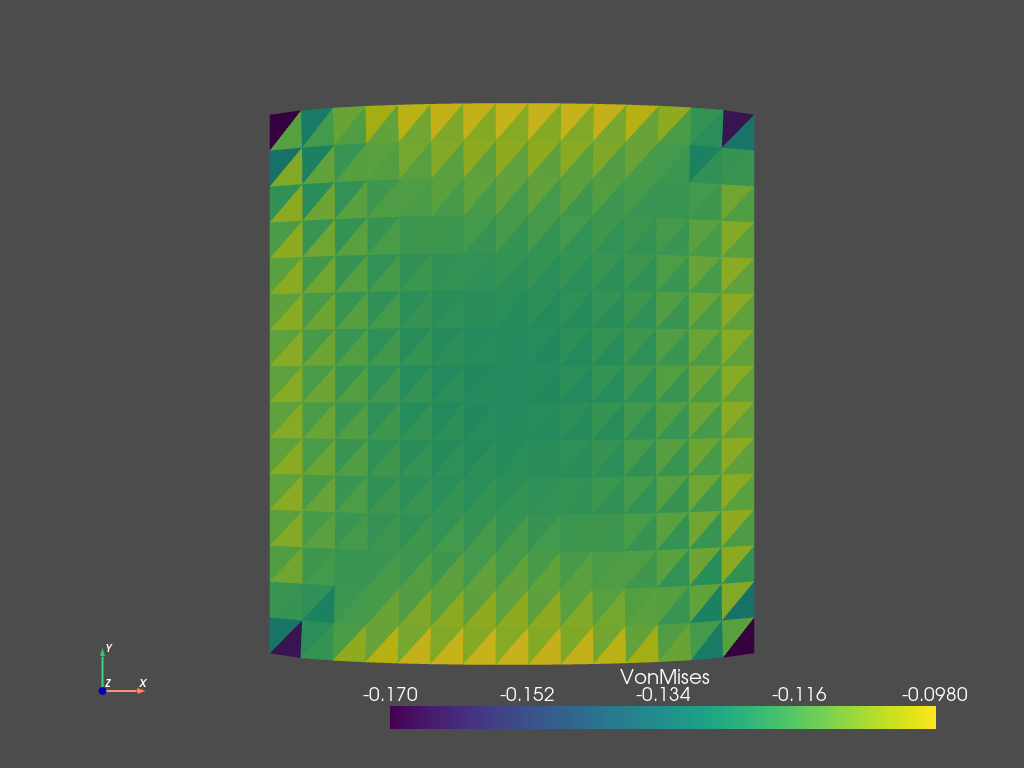

In [90]:

V_stress_scalar = dolfinx.fem.FunctionSpace(domain, ("DG", 0))
stress_xx_expr = dolfinx.fem.Expression(stress[0,0], V_stress_scalar.element.interpolation_points())
stress_xx_function = dolfinx.fem.Function(V_stress_scalar,name="sigmaxx")
stress_xx_function.interpolate(stress_xx_expr)


pyvista.set_jupyter_backend("none")
warped.cell_data["VonMises"] = stress_xx_function.vector.array
warped.set_active_scalars("VonMises")
p = pyvista.Plotter()
p.add_mesh(warped)
p.show_axes()
p.view_xy()
p.show()

**Exercise.** 
Let be $u^{*}$ and $P^{*}$ the displacement field obtained on a domain $\Omega^*=[0,1]\times[0,W/L]\times[0,W/L]$ for a Young module $E=1$ and a load $f=1$ applied at the right end. 
Determine by dimensional analysis the analytical formulas giving the 
displacement $u$ and the potential energy $P$ for any values of  $E$,  load $f$, and for any domain obtained by a rescaling of $\Omega^*$ with a length-scale $L_0$.
